In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datascience import *
import numpy as np
%matplotlib inline

## An Example: VAT taxes in French Restaurants

The dataset in this example is taken from Benzarti and Carloni's paper *Who Benefits from VAT cuts? Evidence from Large VAT Reform in France*. 


In July 2009, the Value Added Tax (VAT) rate for meals consumed in French sit-down restaurants was reduced from 19.6% to 5.5%. Since the VAT is charged directly to consumers, we will graph the demand curve pre and post tax to see the quantitative effects of the tax.

The first few parts of this example go through some data wrangling procedures that ultimately allow us to get the data in a format we want. Do not worry too much if this has not yet been fully covered in Data 8; the concepts should be taught within the next couple weeks.

### Step 1: Reading in Data

In `prices.csv`, we will see the average price of a sit-down meal in France across months from January 2006 to December 2011.

In [172]:
prices = Table.read_table("prices.csv")
prices

year,month,price
2003,1,100.52
2003,2,100.71
2003,3,100.95
2003,4,101.29
2003,5,101.38
2003,6,101.57
2003,7,101.91
2003,8,102.18
2003,9,102.25
2003,10,102.49


In [130]:
prices = prices.where("year", are.above(2005))

In `quantities.csv`, we will see the average price of a sit-down meal in France across months from January 1995 to April 2015. Note that the quantity value across time periods is indexed relative to the year 2010, in which the average quantity consumed was 100 in 2010. 

In [173]:
quantities = Table.read_table("quantities.csv")
quantities

year,month,quantity
2015,4,88.8
2015,3,86.8
2015,2,88.6
2015,1,88.6
2014,12,88.9
2014,11,89.3
2014,10,90.3
2014,9,89.5
2014,8,90.7
2014,7,89.1


Lastly, in `cpi.csv`, we have the data for the French Consumer Price Index (CPI). The CPI is also indexed, but this time relative to the yaer 1998. Having the CPI allows us to adjust for inflation, allowing us to calculate real prices. Below, we will calculate prices across time in terms of "2010 dollars", i.e. the real price of a meal if measured in 2010. 

In [174]:
cpi = Table.read_table("cpi.csv")
cpi

year,cpi
1998,100
1999,100.5
2000,102.2
2001,103.9
2002,105.9
2003,108.1
2004,110.4
2005,112.4
2006,114.23
2007,115.92


### Step 2: Joining the Data

We would like a way to combine our data, currently spread across 3 tables, into a single table. This will allow us to more easily conduct table operations on it. Since all of our tables are based on time-series data, we can join them across shared time attributes. 

First, we join `price` with `quantities`. Notably, 2 columns (`year` and `month`) must match for us in both tables to join the data correctly together. In order to join on 2 columns instead of just 1, we provide a list of column labels.

In [175]:
prices_and_quantities = prices.join(["year", "month"], quantities, ["year", "month"])
prices_and_quantities

year,month,price,quantity
2003,1,100.52,108.7
2003,2,100.71,108
2003,3,100.95,109
2003,4,101.29,108.4
2003,5,101.38,108.7
2003,6,101.57,108.6
2003,7,101.91,109.4
2003,8,102.18,110.5
2003,9,102.25,113.8
2003,10,102.49,107.8


Now, we join this table with CPI data to create a final table called `meals`. Here, since CPI is measured annually, we only join them on the shared `year` column.

In [134]:
meals = prices_and_quantities.join("year", cpi, "year")
meals

year,month,price,quantity,cpi
2006,1,108.49,107,114.23
2006,2,108.76,105.4,114.23
2006,3,109.02,105,114.23
2006,4,109.28,105.5,114.23
2006,5,109.43,105.7,114.23
2006,6,109.69,103.4,114.23
2006,7,109.82,105.8,114.23
2006,8,110.18,105.9,114.23
2006,9,110.27,109.2,114.23
2006,10,110.64,109.3,114.23


Note that since the `prices` table is already sorted in chronological order, `meals` will also be sorted the same way.

### Step 3: Cleaning the Data

Let's first 'normalize' the prices by controlling for inflation, using 2010 as a 'base year'. In 2010, the CPI was 121.1:

In [135]:
cpi.where("year", 2010)

year,cpi
2010,121.1


In [136]:
cpi_2010 = cpi.where("year", 2010).column("cpi").item(0)
cpi_2010

121.1

That means to get a year $t$'s prices in 2010 dollars, we must normalize by dividing by that year's CPI and multiplying by the 2010 CPI. Intuitively, we do this to 'cancel' out the units measured in year $t$ dollars and convert it to 2010 dollars.
$$\text{Price in 2010 dollars} = \text{Price in year $t$ dollars} \times \frac{\text{CPI}_{2010}}{\text{CPI}_t}$$
Now, we calculate this column and add it back into the `meals` table:

In [137]:
adjusted_price = meals.column("price") * cpi_2010 / meals.column("cpi")
meals = meals.with_columns("adj_price", adjusted_price)
meals

year,month,price,quantity,cpi,adj_price
2006,1,108.49,107,114.23,115.015
2006,2,108.76,105.4,114.23,115.301
2006,3,109.02,105,114.23,115.577
2006,4,109.28,105.5,114.23,115.852
2006,5,109.43,105.7,114.23,116.011
2006,6,109.69,103.4,114.23,116.287
2006,7,109.82,105.8,114.23,116.425
2006,8,110.18,105.9,114.23,116.806
2006,9,110.27,109.2,114.23,116.902
2006,10,110.64,109.3,114.23,117.294


Next, we will break up the table into 2 tables, corresponding to before the tax and after the tax. Recall the tax was reduced beginning in July 2009. 

Unfortunately, there isn't a quick and clean way using `.where` to filter out our data into 2 tables. For example, using `meals.where("year", are.below(2010)).where("month", are.below(7))` to get all pre-tax periods will return observations where **both** the month is less than 7 and the year is less than 2010, so that a time period like November 2008 will not be included.

Instead, we resort to a slightly 'hacky' way to split up our data by adding a 'time index' column, since the data is already sorted.

In [138]:
meals = meals.with_column("time index", np.arange(meals.num_rows))
meals

year,month,price,quantity,cpi,adj_price,time index
2006,1,108.49,107,114.23,115.015,0
2006,2,108.76,105.4,114.23,115.301,1
2006,3,109.02,105,114.23,115.577,2
2006,4,109.28,105.5,114.23,115.852,3
2006,5,109.43,105.7,114.23,116.011,4
2006,6,109.69,103.4,114.23,116.287,5
2006,7,109.82,105.8,114.23,116.425,6
2006,8,110.18,105.9,114.23,116.806,7
2006,9,110.27,109.2,114.23,116.902,8
2006,10,110.64,109.3,114.23,117.294,9


Now, we will look for the index of the July 2009 time period. Every time period pre-tax will have a time index smaller, and every time period post-tax will have a time index equal or larger.

In [139]:
meals.where("year", 2009).where("month", 7)

year,month,price,quantity,cpi,adj_price,time index
2009,7,116.64,99.6,119.29,118.41,42


In [140]:
index = meals.where("year", 2009).where("month", 7).column("time index").item(0)
index

42

In [141]:
pre = meals.where("time index", are.below(index))
post = meals.where("time index", are.above_or_equal_to(index))

In [162]:
pre

year,month,price,quantity,cpi,adj_price,time index
2006,1,108.49,107,114.23,115.015,0
2006,2,108.76,105.4,114.23,115.301,1
2006,3,109.02,105,114.23,115.577,2
2006,4,109.28,105.5,114.23,115.852,3
2006,5,109.43,105.7,114.23,116.011,4
2006,6,109.69,103.4,114.23,116.287,5
2006,7,109.82,105.8,114.23,116.425,6
2006,8,110.18,105.9,114.23,116.806,7
2006,9,110.27,109.2,114.23,116.902,8
2006,10,110.64,109.3,114.23,117.294,9


In [161]:
post

year,month,price,quantity,cpi,adj_price,time index
2009,7,116.64,99.6,119.29,118.41,42
2009,8,116.5,98.7,119.29,118.268,43
2009,9,116.52,98.6,119.29,118.288,44
2009,10,116.57,99.9,119.29,118.339,45
2009,11,116.64,99.5,119.29,118.41,46
2009,12,116.64,98.9,119.29,118.41,47
2010,1,116.65,98.1,121.1,116.65,48
2010,2,116.75,99.4,121.1,116.75,49
2010,3,116.95,99.8,121.1,116.95,50
2010,4,117,101.5,121.1,117,51


### Step 4: Plotting our Results

Now let's construct a scatter plot. Do not worry if you do not understand the code below; because we would like to overlay the plots, we utilize a slightly different set of functions in the `matplotlib` library.

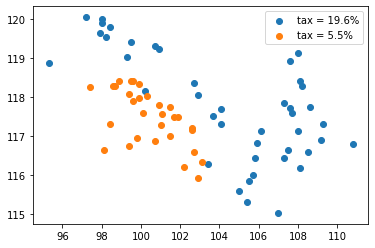

In [144]:
plt.scatter(pre.column("quantity"), pre.column("adj_price"), label = "tax = 19.6%")
plt.scatter(post.column("quantity"), post.column("adj_price"), label = "tax = 5.5%")
plt.legend();

In [165]:
def minimize_error(slope, intercept_pre, intercept_post):
    pre_preds = slope * pre.column("quantity") + intercept_pre
    pre_errors = pre.column("price") - pre_preds
    post_preds = slope * post.column("quantity") + intercept_post
    post_errors = post.column("price") - post_preds
    # errors = np.concatenate([pre_errors, post_errors])
    # return np.mean(np.abs(errors))#np.sqrt(np.mean(errors ** 2))
    return np.sqrt(np.mean(pre_errors ** 2)) + np.sqrt(np.mean(post_errors ** 2))

In [166]:
minimize(minimize_error)

array([ -0.41022036, 156.44980217, 159.32195768])

In [167]:
res = minimize(minimize_error)

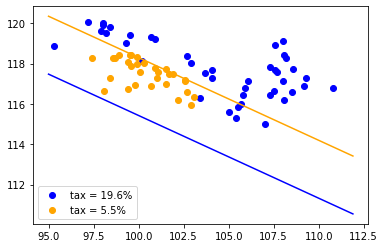

In [168]:
plt.scatter(pre.column("quantity"), pre.column("adj_price"), label = "tax = 19.6%", c ='b')
plt.scatter(post.column("quantity"), post.column("adj_price"), label = "tax = 5.5%", c= 'orange')
x=np.arange(95, 112, 0.1)
plt.plot(x, x*res[0] + res[1], c = 'b')
plt.plot(x, x*res[0] + res[2], c = 'orange')
plt.legend();

In [191]:
p = pd.read_stata("/Users/alanliang/Downloads/114723-V1/data/AEJPol-2017-0504_DATA_prices_subsector.dta")
q = pd.read_csv("/Users/alanliang/Downloads/114723-V1/data/AEJPol-2017-0504_DATA_va_volume_combined.csv", engine = 'python')
c = pd.read_stata("/Users/alanliang/Downloads/114723-V1/data/AEJPol-2017-0504_DATA_cpi.dta")


In [193]:
merged = p.merge(q, left_on = ["year", "month"], right_on = ["year", "month"])
merged = merged.merge(c, on = "year")
merged

,item,price,year,month,time,trad,rapide,caf�,cpi
0,Traditional Meal,100.519997,2003.0,1.0,Jan-2003,108.7,83.0,116.3,108.099998
1,Traditional Meal,100.709999,2003.0,2.0,2,108.0,84.9,115.3,108.099998
2,Traditional Meal,100.949997,2003.0,3.0,3,109.0,85.2,115.8,108.099998
3,Traditional Meal,101.290001,2003.0,4.0,4,108.4,85.0,114.6,108.099998
4,Traditional Meal,101.379997,2003.0,5.0,5,108.7,87.0,116.9,108.099998
...,...,...,...,...,...,...,...,...,...
103,Traditional Meal,119.959999,2011.0,8.0,104,101.7,101.2,95.4,123.660004
104,Traditional Meal,120.059998,2011.0,9.0,105,101.1,102.2,96.9,123.660004
105,Traditional Meal,120.269997,2011.0,10.0,106,100.9,101.8,97.6,123.660004
106,Traditional Meal,120.389999,2011.0,11.0,107,99.6,100.8,95.9,123.660004


In [194]:
merged['adj'] = merged.price / merged.cpi * 121.1

In [195]:
merged = merged.sort_values(["year", "month"])
merged

,item,price,year,month,time,trad,rapide,caf�,cpi,adj
0,Traditional Meal,100.519997,2003.0,1.0,Jan-2003,108.7,83.0,116.3,108.099998,112.608437
1,Traditional Meal,100.709999,2003.0,2.0,2,108.0,84.9,115.3,108.099998,112.821289
2,Traditional Meal,100.949997,2003.0,3.0,3,109.0,85.2,115.8,108.099998,113.090141
3,Traditional Meal,101.290001,2003.0,4.0,4,108.4,85.0,114.6,108.099998,113.471031
4,Traditional Meal,101.379997,2003.0,5.0,5,108.7,87.0,116.9,108.099998,113.571861
...,...,...,...,...,...,...,...,...,...,...
103,Traditional Meal,119.959999,2011.0,8.0,104,101.7,101.2,95.4,123.660004,117.476593
104,Traditional Meal,120.059998,2011.0,9.0,105,101.1,102.2,96.9,123.660004,117.574524
105,Traditional Meal,120.269997,2011.0,10.0,106,100.9,101.8,97.6,123.660004,117.780174
106,Traditional Meal,120.389999,2011.0,11.0,107,99.6,100.8,95.9,123.660004,117.897690


In [196]:
merged[merged.year == 2009]

,item,price,year,month,time,trad,rapide,caf�,cpi,adj
72,Traditional Meal,117.750000,2009.0,1.0,Jan-2009,98.2,97.4,106.2,119.290001,119.536636
73,Traditional Meal,117.839996,2009.0,2.0,74,97.9,95.3,105.8,119.290001,119.627991
74,Traditional Meal,118.010002,2009.0,3.0,75,98.4,96.5,99.3,119.290001,119.800575
75,Traditional Meal,118.099998,2009.0,4.0,76,98.0,96.9,104.9,119.290001,119.891937
76,Traditional Meal,118.199997,2009.0,5.0,77,98.0,96.7,100.1,119.290001,119.993454
77,Traditional Meal,118.260002,2009.0,6.0,78,97.2,95.4,97.3,119.290001,120.054375
78,Traditional Meal,116.639999,2009.0,7.0,Jul-2009,99.6,99.1,97.7,119.290001,118.409790
79,Traditional Meal,116.500000,2009.0,8.0,80,98.7,99.2,98.1,119.290001,118.267662
80,Traditional Meal,116.519997,2009.0,9.0,81,98.6,97.7,97.6,119.290001,118.287964
81,Traditional Meal,116.570000,2009.0,10.0,82,99.9,98.4,98.7,119.290001,118.338730


In [197]:
pre = merged.iloc[:78,:]
post = merged.iloc[78:,:]


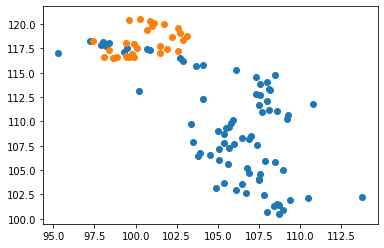

In [202]:
plt.scatter(pre.trad, pre.price)
plt.scatter(post.trad, post.price)